### Importing the necessary libraries

In [ ]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

In [ ]:
!pip install -U darts
!pip install -U optuna
!pip install -U matplotlib

In [1]:
%matplotlib inline

import torch
import random
import numpy as np
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MaxAbsScaler, StandardScaler, MinMaxScaler

from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
from darts.metrics import mape as mape_darts
from darts.metrics import mase as mase_darts
from darts.metrics import mae as mae_darts
from darts.metrics import rmse as rmse_darts
from darts.metrics import smape as smape_darts
from darts.metrics import mse as mse_darts




from darts.datasets import ElectricityDataset
from darts.models import TCNModel, LinearRegressionModel, LightGBMModel, NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, rmse, mape, mae, mase
from darts.utils.likelihood_models import GaussianLikelihood
from darts.utils.missing_values import extract_subseries, fill_missing_values
import datetime
from datetime import timedelta

import logging
from functools import reduce

In [2]:
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
#from pytorch_lightning.profiler import Profiler, AdvancedProfiler
from torchmetrics import MeanAbsolutePercentageError

In [4]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

### Defining functions

In [5]:
def select_range(df,start_date,end_date):
  """
  Parameters: df : pd.Dataframe : the dataframe that we want to check for missing datetime values
              start_date : str : the desired start date of our df
              end_date : str : the desired end_date of our df

  Returns : ts : the cut df from start_date to end_date
"""
  ts=df.copy()
  start = pd.Timestamp(start_date)
  end = pd.Timestamp(end_date)
  ts=ts.loc[start:end]
  return ts

In [6]:
def read_csv_and_set_index(file,col=None,format=None,date_parse=None, separator = None):
  """
   Parameters: file : str: the name of the csv file that we want to save as df
               col : str : the name of the column we want to set as index
            
   Returns : df : pd.DataFrame : the df from the csv file, with col as index
"""
  if (date_parse is not None):
    dateparse = lambda x: datetime.datetime.strptime(x, '%Y%m%d%H%M%S')
    parse = [col]
  else :
    parse = False
    dateparse = None

  df = pd.read_csv(file,parse_dates=parse, date_parser=dateparse,sep=separator)
  if (col is not None):
    df = df.set_index(col)
  df.index=pd.to_datetime(df.index)
  return df

In [7]:
def convert_to_timeseries(df,col=None, resolution=None):

  """"
    Parameters: df : pd.DataFrame : the df we want to convert to TimeSeries
                resolution : str : the resolution in which we want to resample
                col : [str] : the column which we want to convert to TimeSeries, if not None, inside brackets
            
   Returns : series : TimeSeries: the converted timeseries from df or df's columns ( if col is not None)
  
"""
  if(resolution is not None):
    df=df.resample(resolution).mean()

  if (col is not None):
    data = df[col]
  else :
    data = df

  series = data.squeeze()
  series = series.astype(np.float32)
  series = TimeSeries.from_series(series)

 

  return series

In [8]:
def split_and_scale(series,test_start_date,scaler_model=None):

  """"
    Parameters: series : TimeSeries : The timeseries we want to split into train, val test and, optionally, scale.
                val_length : int : the length of the Timeseries we want to keep as a validation set
                scaler_model : sklearn.preprocessing. : the model of scaler to be fitted in our data.
            
   Returns : train : darts.TimeSeries: the timeseries we will use as a training set, meaning the input series timeseries, but cut at the val_start_date
             val   : TimeSeries: the timeseries we will use as a validation set, meaning the input series timeseries, but startint from the val_start_date
            series_transformed : TimeSeries : The timeseries with the scaled_model fitted and transformed
"""

  if (scaler_model is not None):
    scaler = Scaler(scaler=scaler_model)
    scaler_x =scaler.fit(series)
    series_transformed = scaler_x.transform(series)       

  else : 
    scaler_x = None
    series_transformed = series
  
  train = series_transformed.drop_after(pd.Timestamp(test_start_date))
  val = series_transformed.drop_before(pd.Timestamp(pd.Timestamp(
        test_start_date) - datetime.timedelta(hours=1)))
  
  return train,val, series_transformed, scaler_x

In [9]:
def append(x, y):
    return x.append(y)


In [10]:
def backtester_final(model,
               series_transformed,
               test_start_date,
               forecast_horizon,
               stride=None,
               series=None,
               transformer_ts=None,
               retrain=False,
               future_covariates=None,
               past_covariates=None,
               path_to_save_backtest=None):
    """ Does the same job with advanced forecast but much more quickly using the darts
    bult-in historical_forecasts method. Use this for evaluation. The other only
    provides pure inference. Provide a unified timeseries test set point based
    on test_start_date. series_transformed does not need to be adjacent to
    training series. if transformer_ts=None then no inverse transform is applied
    to the model predictions.
    Parameters
    ----------
    Returns
    ----------
    """
    # produce the fewest forecasts possible.
    if stride is None:
        stride = forecast_horizon
    test_start_date = pd.Timestamp(test_start_date)
    from functools import reduce

    # produce list of forecasts
    #print("backtesting starting at", test_start_date, "series:", series_transformed)
    backtest_series_transformed = model.historical_forecasts(series_transformed,
                                                             future_covariates=future_covariates,
                                                             past_covariates=past_covariates,
                                                             start=test_start_date,
                                                             forecast_horizon=forecast_horizon,
                                                             stride=stride,
                                                             retrain=retrain,
                                                             last_points_only=False,
                                                             verbose=False)
    


    # flatten lists of forecasts due to last_points_only=False
    if isinstance(backtest_series_transformed, list):
        backtest_series_transformed = reduce(
            append, backtest_series_transformed)

    # inverse scaling
    if transformer_ts is not None:
        backtest_series = transformer_ts.inverse_transform(
            backtest_series_transformed)
        series = transformer_ts.inverse_transform(
            series_transformed)
    else:
        series = series_transformed
        backtest_series = backtest_series_transformed
        print("\nWarning: Scaler not provided. Ensure model provides normal scale predictions")
        logging.info(
            "\n Warning: Scaler not provided. Ensure model provides normal scale predictions")
        

    # plot all test
    fig1 = plt.figure(figsize=(15, 8))
    ax1 = fig1.add_subplot(111)
    backtest_series.plot(label='forecast')
    series \
        .drop_before(pd.Timestamp(pd.Timestamp(test_start_date) - datetime.timedelta(days=7))) \
        .drop_after(backtest_series.time_index[-1]) \
        .plot(label='actual')
    ax1.legend()
    ax1.set_title(
        f'Backtest, starting {test_start_date}, {forecast_horizon}-steps horizon')
    # plt.show()

    # plot one week (better visibility)
    forecast_start_date = pd.Timestamp(
        test_start_date + datetime.timedelta(days=7))

    fig2 = plt.figure(figsize=(15, 8))
    ax2 = fig2.add_subplot(111)
    backtest_series \
        .drop_before(pd.Timestamp(forecast_start_date)) \
        .drop_after(forecast_start_date + datetime.timedelta(days=7)) \
        .plot(label='Forecast')
    series \
        .drop_before(pd.Timestamp(forecast_start_date)) \
        .drop_after(forecast_start_date + datetime.timedelta(days=7)) \
        .plot(label='Actual')
    ax2.legend()
    ax2.set_title(
        f'Weekly forecast, Start date: {forecast_start_date}, Forecast horizon (timesteps): {forecast_horizon}, Forecast extended with backtesting...')
   
    # Metrics
    test_series =  series.drop_before(pd.Timestamp(pd.Timestamp(
        test_start_date) - datetime.timedelta(hours=1)))
    train_series = series.drop_after(pd.Timestamp(test_start_date))

    test_series_pos, null_date = drop_zeros(test_series)
    backtest_series_pos, null_date = drop_zeros(backtest_series,null_date)
    train_series_pos, nulls = drop_zeros(train_series,backwards = True)

    #test_series_pos = test_series
    #backtest_series_pos = backtest_series
    #train_series_pos =train_series
    

    
    nrmse_max =rmse_darts(
            test_series_pos,
            backtest_series_pos) / (test_series_pos.pd_dataframe().max()[0] - test_series_pos.pd_dataframe().min()[0])

    nrmse_mean =rmse_darts(
            test_series_pos,
            backtest_series_pos) / (test_series_pos.pd_dataframe().mean()[0])


    metrics = {
        
        "smape": smape_darts(
            test_series_pos,
            backtest_series_pos),
        "mase": mase_darts(
            test_series_pos,
            backtest_series_pos,
            insample=train_series_pos,m=1),
        "mae": mae_darts(
            test_series_pos,
            backtest_series_pos),
        "rmse": rmse_darts(
            test_series_pos,
            backtest_series_pos),
        "mse" :mse_darts(
            test_series_pos,
            backtest_series_pos),
        "mape": mape_darts(
           test_series_pos,
          backtest_series_pos),
        "nrmse_mean" : nrmse_mean, 
        "nrmse_max" : nrmse_max
       }

    

    for key, value in metrics.items():
        print(key, ': ', value)



    return {"metrics": metrics, "eval_plot": plt, "backtest_series": backtest_series}


In [11]:
def eval_model(test_set, preds):
    
    metrics = {
        
        "mse" : mean_squared_error(test_set, preds),
        "rmse" :mean_squared_error(test_set, preds)**(0.5),
        "mape" :mean_absolute_percentage_error(test_set, preds),
        "mae" : mean_absolute_error(test_set, preds)
    }
    
    
    plt.figure(figsize=(15, 5))

    for key, value in metrics.items():
        print(key, ': ', value)


In [12]:
def drop_zeros(series,null_dates = None,backwards = False ):

  """
  Parameters : series :Union[darts.Timeseries, series ]
  null_dates : list of datetime indexes
  column : str : the name of the column
  backwards : bool : True if we want to reindex our df back from a date and backwards, False if we want to reindex our df from a date and forward

  This function takes a series and drops the values that are zero if null_dates = None, otherwise it drops the rows with index in the null_dates list.
  Also, it reindexes the series, either from a date ( 31/12/2021 here) and after or from a date and before.
  It is used for dropping null values in order to calculate MAPE (excluding the zero values of the timeseries)
  Returns: series : Union[darts.Timeseries, series]
          null_dates : a list containing the indexes of zero values, if null_dates (input parameter) is None 
  """

  temp = series.pd_dataframe(copy=True)
  col =temp.columns[0] ## the name of the column

  if (null_dates is None):
    null_dates = temp[temp[col] == 0].index
  
  temp = temp.drop(index =null_dates)

  if backwards is True : 
     idx= pd.Index(pd.date_range(end='31/12/2021', periods=len(temp)))
  else : 
     idx= pd.Index(pd.date_range(start='1/1/2022', periods=len(temp)))


 
  temp = temp.set_index(idx)
  
  temp = temp.squeeze()
  temp = temp.astype(np.float32)
  temp = TimeSeries.from_series(temp)

 

  return temp , null_dates


In [14]:

def feature_target_split(df,col_name, lookback_window=24*3, forecast_horizon=1):# lookback_window: 168 = 7 days(* 24 hours)
    """
    
    **lookback_window**
    In a for-loop of 'lookback_window' max iterations, starting from 0 
    At N-th iteration (iter): 
        1. create a shifted version of 'Load' column by N rows (vertically) and 
        2. stores it in a column* (feature_'N')
    Same pseudo-code for 'forecast_horizon' loop
    
    *At first iterations of both loops, the new columns (feature/target) are going to be firstly created
    but for each iteration, the same columns are going to be used
    
    We store each new column created in a dictionary which, at the end, convert it to dataframe
    The reason behind this choice is that if it was initially a dataframe, for large amount of loops,
    fast insertion of new columns would cause a performance issue (slower) even though the end result
    would propably not be altered
    
    Parameters: 
        df: pandas.dataframe containing column to parse
        lookback_window: lookback_window - # feature columns - # inputs in model
        forecast_horizon: forecast_horizon - # target columns - # outputs in model
        col_name - str - the name of the column containing t-- -- - -to be filled
    ----------
    Returns
        'subset'_X: pandas.dataframe containing features of df after preprocess for model
        'subset'_Y: pandas.dataframe containing targets of df after preprocess for model
    -------
    """

    # Reset "Unnamed: 0" based on concated df 
    df['Unnamed: 0'] = range(1, len(df) + 1)

    df_copy = df.copy()    

    df_new = {}
        
    for inc in range(0,int(lookback_window)):
        df_new['feature_' + str(inc)] = df_copy[col_name].shift(-inc)

    # shift 'load' column permanently for as many shifts happened at 'lookback_window' loops  
    df_copy[col_name] = df_copy[col_name].shift(-int(lookback_window))
                    
    for inc in range(0,int(forecast_horizon)):
        df_new['target_' + str(inc)] = df_copy[col_name].shift(-inc)    
    
    df_new = pd.DataFrame(df_new, index=df_copy.index)
    df_new = df_new.dropna().reset_index(drop=True)    
                            
    return df_new.iloc[:,:lookback_window] , df_new.iloc[:,-forecast_horizon:]

## Before Forecasting

### Reading CSVs

In [15]:
power =read_csv_and_set_index('power_dt.csv','index')
current =read_csv_and_set_index('current_dt.csv','index')
voltage =read_csv_and_set_index('voltage_dt.csv','index')
weather = read_csv_and_set_index('weather.csv',col='time [UTC](yyyymmddHHMM)',date_parse = True, separator =';')

<ipython-input-6-bfde5aa6abae>:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file,parse_dates=parse, date_parser=dateparse,sep=separator)
<ipython-input-6-bfde5aa6abae>:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file,parse_dates=parse, date_parser=dateparse,sep=separator)
<ipython-input-6-bfde5aa6abae>:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file,parse_dates=parse, date_parser=dateparse,sep=separator)


### Power data editing

We are going to edit the active and reactive power's values of the PV and the headquarters loads in order to calculate MAPE. As MAPE is defective when working with series that contain zero-ish values, we set the following values to zero and we will later exclude them from the MAPE calculating process:
Active Power of W4 will be set to zero for values <1
Active Power of PV will be set to zero for values >-1 (as PV's active power is negative)
Reactive Power of W4 will be set to zero for values >-1
Reactive Power of W6 (PV) will be set to zero for values <1  

In [16]:
idx = power[power['reactive_w6']<1].index

In [17]:
power.loc[idx,'reactive_w6'] =0 

In [18]:
idx1 = power[power['active_w6']>-1].index
power.loc[idx1,'active_w6'] =0 

In [20]:
idx2 = power[power['reactive_w4']>-1].index
power.loc[idx2,'reactive_w4'] =0 

In [21]:
idx3 = power[power['active_w4']<1].index
power.loc[idx3,'active_w4'] =0 

# Historical Forecasts 

## Forecasting of the PV's (W6) active power 


### Before Model Selection

####Creation and basic editing of Timeseries

#####Converting to Timeseries

We already have a datetime type of index at our df. We are going to convert our df's selected column ( current of w4, power of w6 etc) to Timeseries. We will then keep the absolute values of the timeseries and keep only the dates prior to the last obervation of weather data --> **to be changed once weather data will be updated**

We convert the part of the dataframe that concerns us, now the PV's active power, to Timeseries, with 60 minutes resolution.

In [29]:
series = convert_to_timeseries(power,['active_w6'],'60min')
series=abs(series)
# if we want to include weather data as past covariates we have to limit our timeseries accordingly to the last observation for weather data
series =series.drop_after(pd.Timestamp('2022-08-03 23:00:00')) ##last observation for weather data


##### Keeping non-missing values of the timeseries

As we have already observed at our exploratory analysis, there are a lot of consecutive missing values, like missing months, for our data. In order to keep the filled values, we are goint to extract the subseries with filled values. The extact_subseries partitions the series into a sequence of sub-series by using significant gaps of missing values. Here as a significant gap we have considered 12 hours.

In [30]:
series= extract_subseries(series,min_gap_size=12)

Then we are going to concatenate the subseries and create one serie, with the index of the first continued for all the other subseries.
Moreover, we save the index of each subserie into a list.

In [31]:
series_concat = series[0]
start_date= series[0].get_timestamp_at_point(0)
end_date=  series[0].get_timestamp_at_point(len(series[0])-1)
idx =pd.Index(pd.date_range(start = start_date, end=end_date, freq='1H'))


In [32]:
for i in range(1,len(series)):
  series_concat = series_concat.concatenate(series[i],ignore_time_axis=True)
  start_date= series[i].get_timestamp_at_point(0)
  end_date=  series[i].get_timestamp_at_point(len(series[i])-1)
  idx_temp =pd.Index(pd.date_range(start = start_date, end=end_date, freq='1H'))
  idx =idx.append(idx_temp)


We fill the missing values with interpolating (fill='auto')

In [33]:
series_concat = fill_missing_values(series_concat, fill='auto')
series = series_concat

#####Alligning weather data with the subseries' datetimes

Keeping only the dates,for weather data, which contained non-missing values for W6's active power

In [34]:
weather_copy = weather.copy()

In [35]:
weather_copy=weather_copy.loc[idx]

Reindexing weather data with the new index of our basic Timeseries data

In [36]:
idx1= pd.Index(pd.date_range(start= series.get_timestamp_at_point(0), end=series.get_timestamp_at_point(len(series)-1), freq='1H'))


In [37]:
weather_copy = weather_copy.set_index(idx1)


#####Separating every weather component(radiation, temperature e.t.c) into different Timeseries 

In [38]:
weather_rad=convert_to_timeseries(weather_copy,'global radiation [W/m^2]','60min')
weather_humidity = convert_to_timeseries(weather_copy,'relative humidity [%]','60min')
weather_temp = convert_to_timeseries(weather_copy,'air temperature [°C]','60min')
weather_cloud = convert_to_timeseries(weather_copy,'cloudcover [%]','60min')
weather_wind = convert_to_timeseries(weather_copy,'wind speed[m/s]','60min')


#### Creating the train/validation Timeseries

Spliting series to train and validation series 


We will split our series to train and validation ones, by calling the custom split_and scale function, giving as a parameter the date when we want to start the testing. We will test our model with non-scaled data.
Here one month is used for testing and the others for training

In [39]:
test_start_date = series.get_timestamp_at_point(len(series)-1) - datetime.timedelta(days=31)

In [40]:
train, val, series_transformed, scaler = split_and_scale(series,test_start_date)

### LighGBM Model without past/ covariates


First we will try the LightGBM Model without any past or future covariates and check its performance

#### Train the model and predict 

After trying many values, we choose 7 days ( 7 x 24 observations) as the lookback window. (lags = 7*24)

In [41]:
lgbm_model = LightGBMModel(lags = 7*24)
lgbm_model.fit(train)

After fitting and training the model with our data we use the backtester_final function to make historical forecasts.

This method uses an expanding training window; it repeatedly builds a training set from the beginning of series. It trains the model on the training set, emits a forecast of length equal to forecast_horizon - here one hour - and then moves the end of the training set forward by stride time steps.

<ipython-input-10-63249f2d3cb3>:100: UserWarning: Parsing '31/12/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  train_series_pos, nulls = drop_zeros(train_series,backwards = True)


smape :  23.966336250305176
mase :  0.40861434
mae :  7.8308187
rmse :  12.469724
mse :  155.494
mape :  28.42886745929718
nrmse_mean :  0.25060883
nrmse_max :  0.10243032


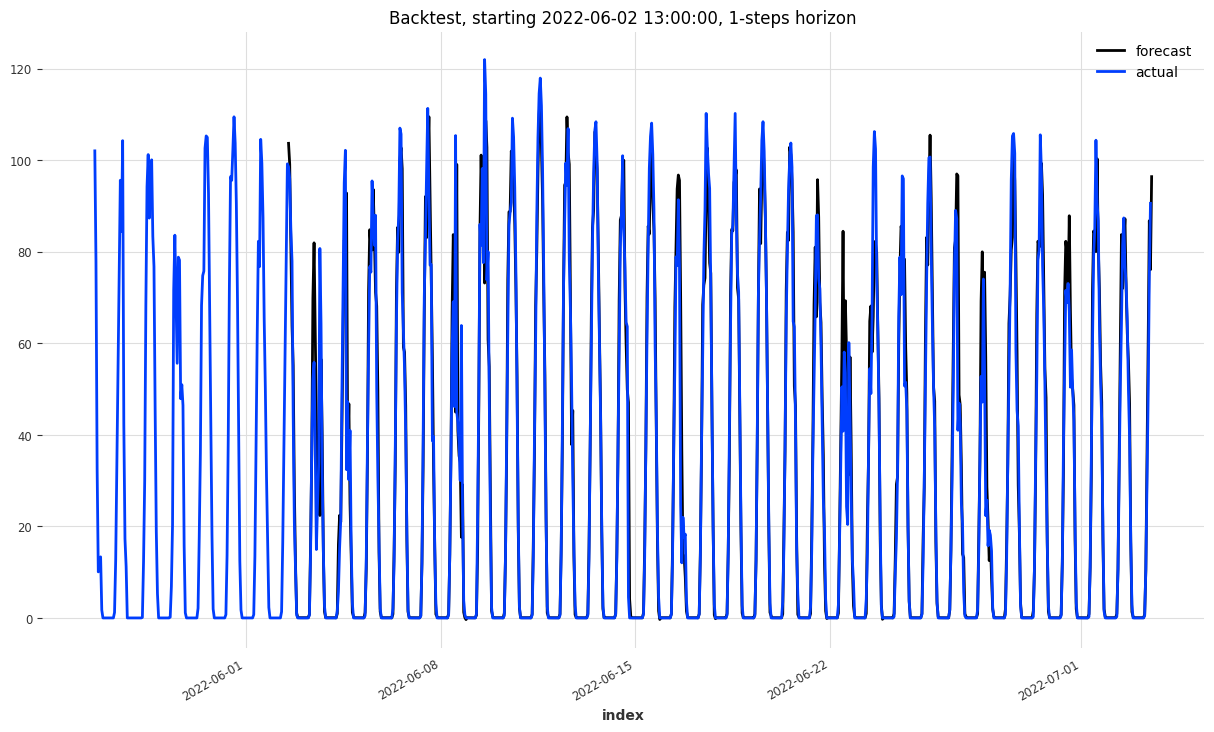

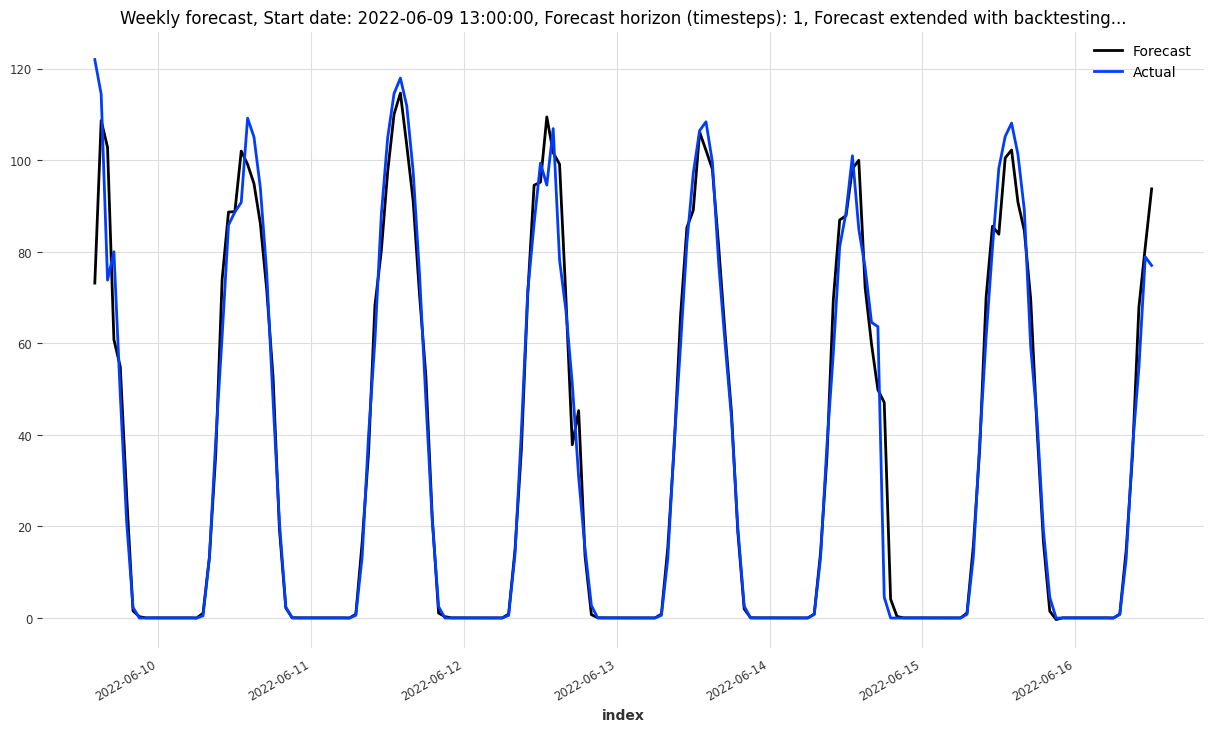

In [42]:
backtest_dict = backtester_final(lgbm_model,series_transformed,test_start_date,1, series=series,transformer_ts=scaler )

We get a MASE error of 0.41. As MASE is defined as MAE / MAE*(Naive)* this value means that the Darts Lightgbm model performs better at forecasting the values of W6 compared to the Naive forecast.It actually has double the accuracy of that of Naive's model 

Saving the returns of the backtester function to variables and saving the metrics into a pd.Dataframe in order to easily compare them with the other models' metrics.

In [43]:
backtest_series = backtest_dict.get("backtest_series")

In [44]:
backtest_metrics = backtest_dict.get("metrics")


In [50]:
metric_pd = pd.DataFrame(backtest_metrics.items(), columns=['Metric', 'LightGBM'])


### Light GBM Model with past covariates

#### Adding past and/or future covariates to LightGBM


We will use the weather data as covariates.
Using the stack function we add multiple timeseries as past covariates. We will use here the globar radiation, the relative humidity and the cloud cover data.
As we have checked both weather and power data are in UTC, so no timezone change should be made.

In [53]:
past_covariates =(weather_temp).stack(weather_cloud).stack(weather_rad) # we use radiation, humidity and cloud cover as past covariates

Splitting our past covariates to train, validation series

In [54]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(past_covariates,test_start_date)


<ipython-input-10-63249f2d3cb3>:100: UserWarning: Parsing '31/12/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  train_series_pos, nulls = drop_zeros(train_series,backwards = True)


smape :  26.696020364761353
mase :  0.41291457
mae :  7.913229
rmse :  12.021231
mse :  144.51
mape :  50.78285336494446
nrmse_mean :  0.24159528
nrmse_max :  0.098746255


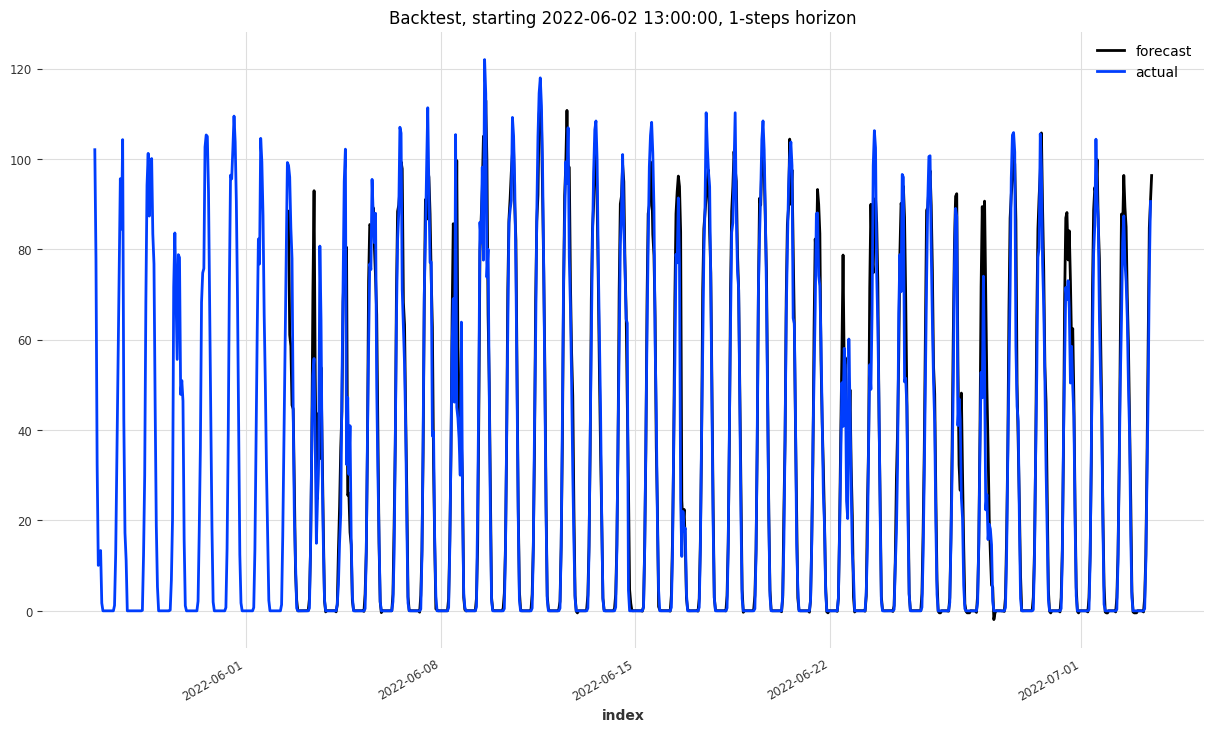

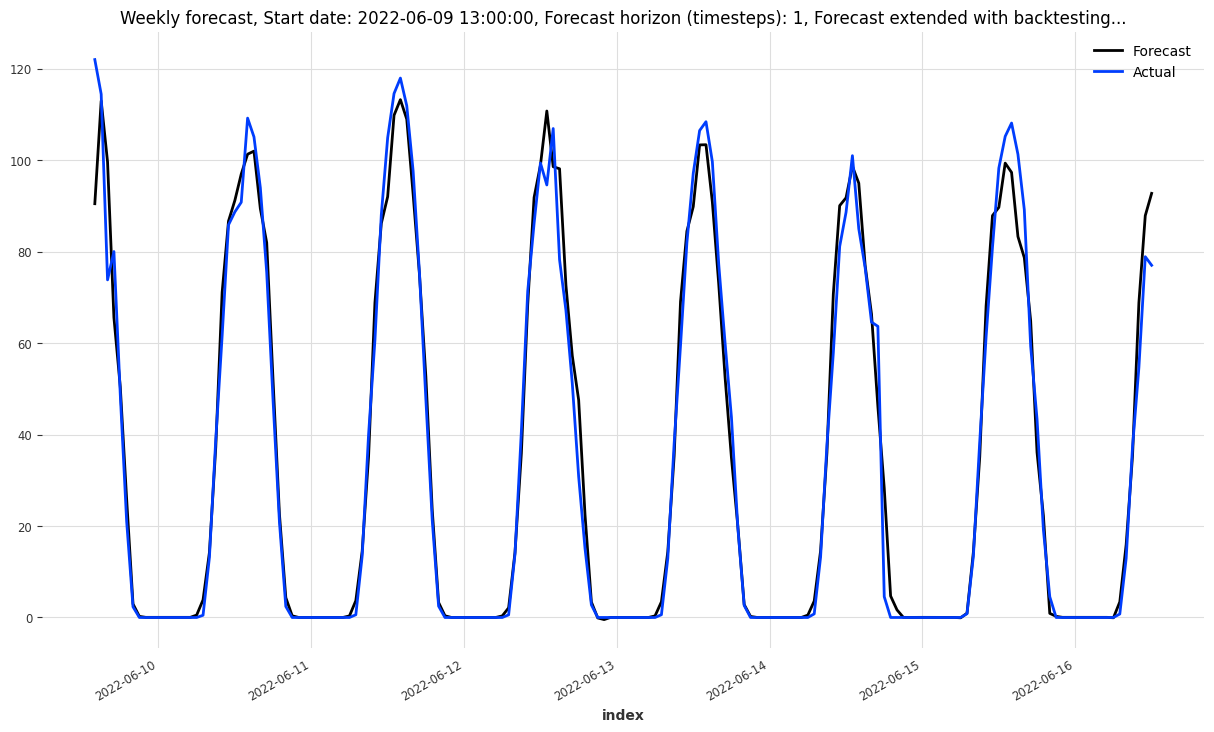

In [61]:
lgbm_model = LightGBMModel(lags = 7*24, lags_past_covariates = 1*24)
lgbm_model.fit(train, past_covariates = train_cov)
backtest_dict_with_cov = backtester_final(lgbm_model,series_transformed,test_start_date,1, series=series,transformer_ts=scaler, past_covariates=series_cov)

Saving the returns - The metrics of the model's performance & appending the existing pd.Dataframe with a new column, containing this case's metrics.

In [65]:
backtest_metrics = backtest_dict_with_cov.get("metrics")

In [66]:
metric_pd["LightGBM with cov"] = metric_pd["Metric"].map(backtest_metrics)

### NBeats Model without covariates

We choose 7 * 24 lags as input chunk length and 1 hour as output chunk length, The rest of the

In [68]:
Nbeats_model = NBEATSModel(input_chunk_length = 7*24,
                           output_chunk_length =1,
                           num_stacks =3,
                           num_blocks = 6,
                           num_layers =3,
                           layer_widths =64,
                           expansion_coefficient_dim = 5 ,
                           n_epochs = 300,
                           batch_size= 1024)

In [ ]:
Nbeats_model.fit(train)

In [70]:
import logging
logging.getLogger("pytorch_lightning.utilities.rank_zero").addHandler(logging.NullHandler())
logging.getLogger("pytorch_lightning.accelerators.cuda").addHandler(logging.NullHandler())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:

<ipython-input-10-63249f2d3cb3>:100: UserWarning: Parsing '31/12/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  train_series_pos, nulls = drop_zeros(train_series,backwards = True)


smape :  25.51656663417816
mase :  0.41814774
mae :  8.013519
rmse :  12.737111
mse :  162.23401
mape :  29.563868045806885
nrmse_mean :  0.2559826
nrmse_max :  0.10462673


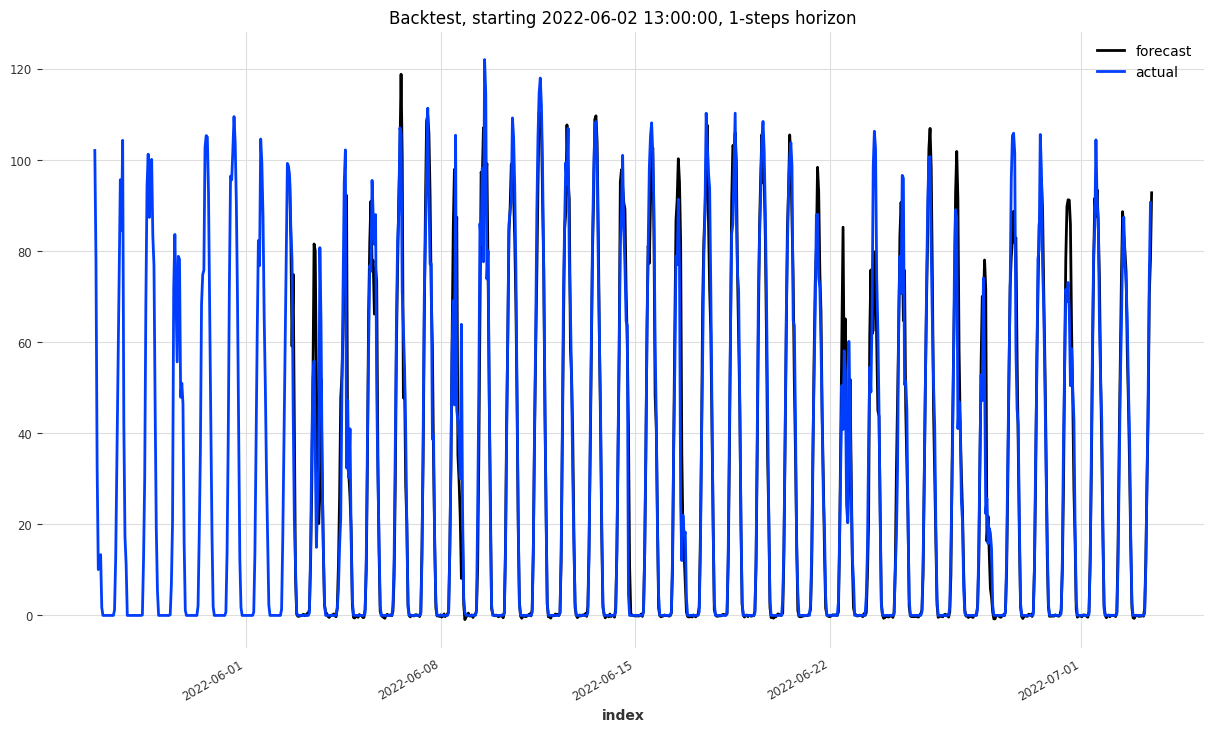

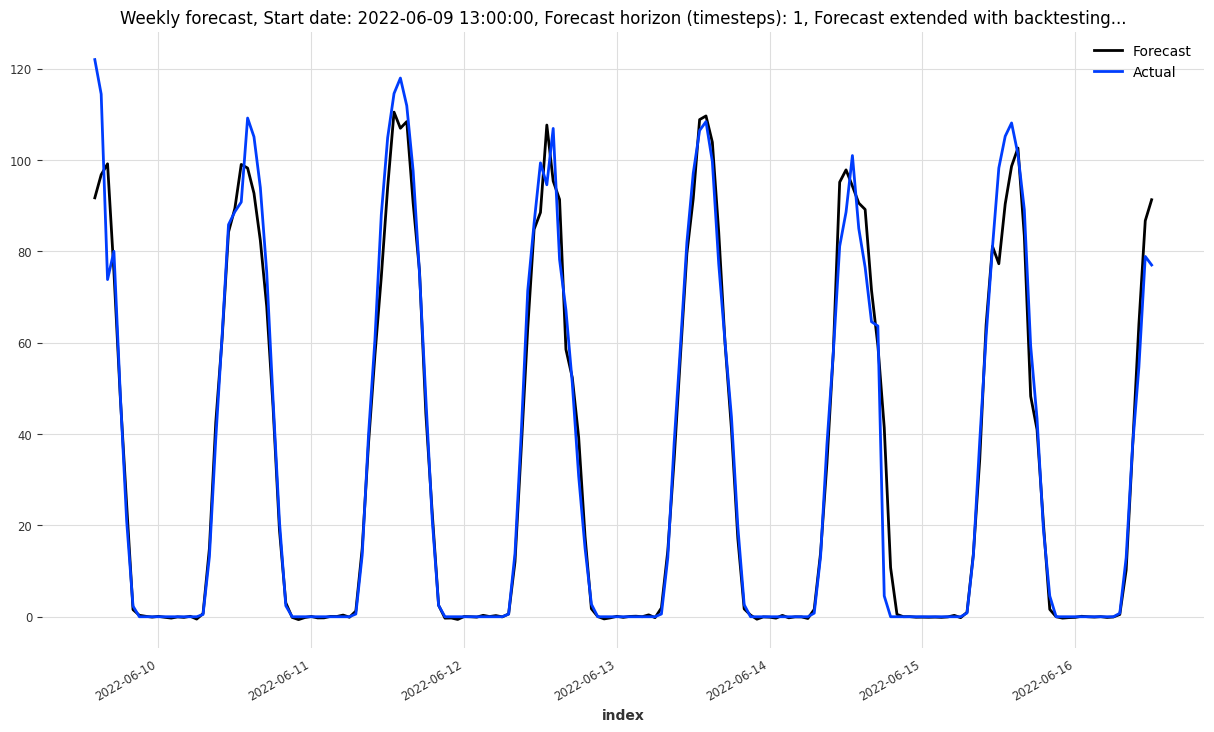

In [73]:
backtest_dict = backtester_final(Nbeats_model,series_transformed,test_start_date,1, series=series,transformer_ts=scaler)

Saving the returns - The metrics of the model's performance 

In [74]:
backtest_metrics = backtest_dict.get("metrics")

In [75]:
metric_pd["NBEATS"] = metric_pd["Metric"].map(backtest_metrics)

In [76]:
metric_pd

,Metric,LightGBM,LightGBM with cov,NBEATS
0,smape,23.966336,26.696020,25.516567
1,mase,0.408614,0.412915,0.418148
2,mae,7.830819,7.913229,8.013519
3,rmse,12.469724,12.021231,12.737111
4,mse,155.494003,144.509995,162.234009
5,mape,28.428867,50.782853,29.563868
6,nrmse_mean,0.250609,0.241595,0.255983
7,nrmse_max,0.102430,0.098746,0.104627


### NBEATS with covariates

Using the stack function to add multiple timeseries as future covariates

In [77]:
past_covariates =(weather_temp).stack(weather_cloud).stack(weather_rad)

Splitting our future covariates to train, validation series

In [78]:
train_cov,  val_cov, series_cov ,sc_cov= split_and_scale(past_covariates,test_start_date)


Selecting parameters, training and making historical forecasts

In [80]:
Nbeats_model = NBEATSModel(input_chunk_length = 7*24,
                           output_chunk_length =1,
                           num_stacks =3,
                           num_blocks = 6,
                           num_layers =3,
                           layer_widths =64,
                           expansion_coefficient_dim = 5 ,
                           n_epochs = 300,
                           batch_size= 1024)

In [81]:
Nbeats_model.fit(train,train_cov)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.0 M 
---------------------------------------------------
1.0 M     Trainable params
4.4 K     Non-trainable params
1.0 M     Total params
4.039     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:

<ipython-input-10-63249f2d3cb3>:100: UserWarning: Parsing '31/12/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  train_series_pos, nulls = drop_zeros(train_series,backwards = True)


smape :  29.234367609024048
mase :  0.5394655
mae :  10.338491
rmse :  15.60688
mse :  243.5747
mape :  48.57542812824249
nrmse_mean :  0.31365746
nrmse_max :  0.12819993


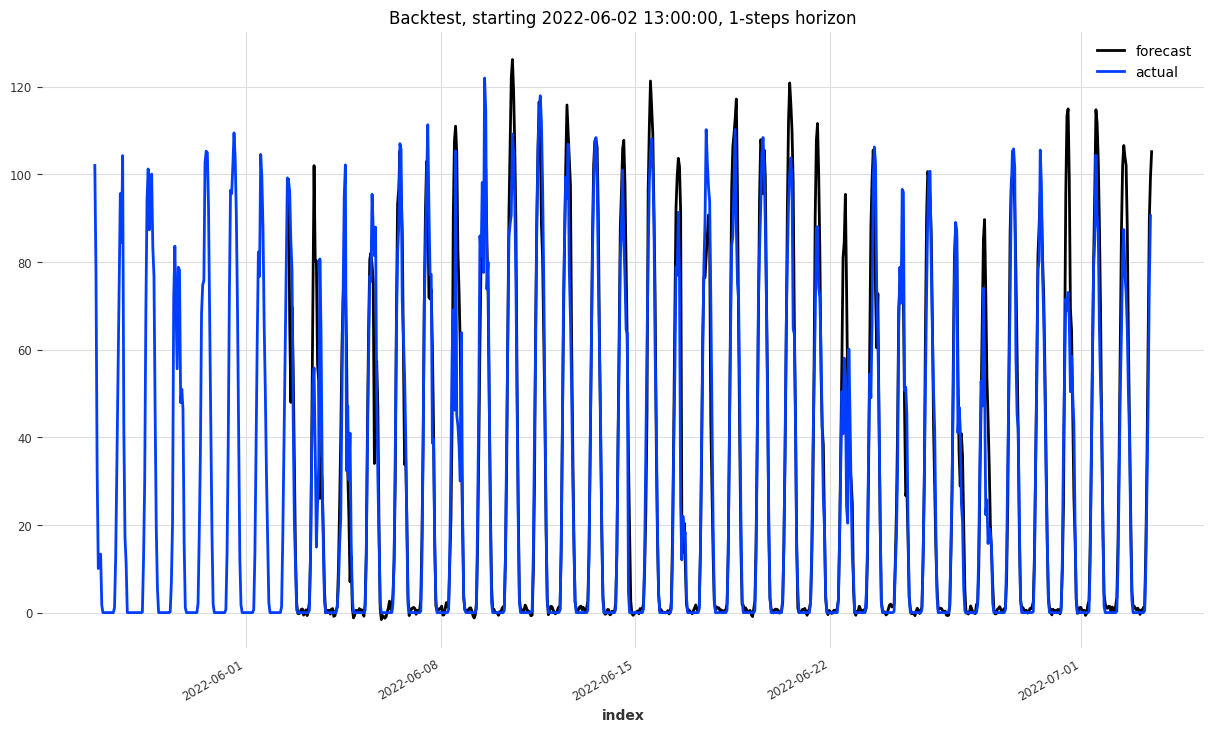

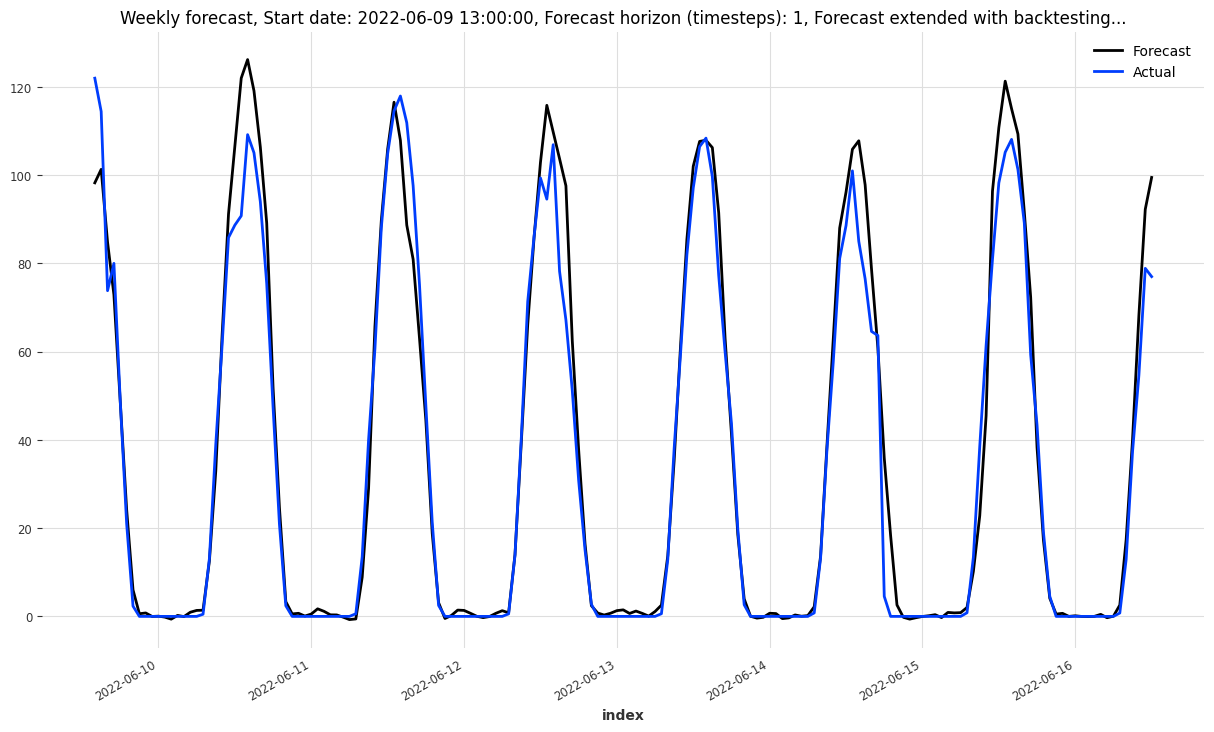

In [83]:
backtest_dict = backtester_final(Nbeats_model,series_transformed,test_start_date,1, series=series,transformer_ts=scaler, past_covariates=series_cov)

Saving the returns - The metrics of the model's performance 

In [84]:
backtest_metrics = backtest_dict.get("metrics")

In [85]:
metric_pd["NBEATS with cov"] = metric_pd["Metric"].map(backtest_metrics)

In [86]:
metric_pd

,Metric,LightGBM,LightGBM with cov,NBEATS,NBEATS with cov
0,smape,23.966336,26.696020,25.516567,29.234368
1,mase,0.408614,0.412915,0.418148,0.539465
2,mae,7.830819,7.913229,8.013519,10.338491
3,rmse,12.469724,12.021231,12.737111,15.606880
4,mse,155.494003,144.509995,162.234009,243.574707
5,mape,28.428867,50.782853,29.563868,48.575428
6,nrmse_mean,0.250609,0.241595,0.255983,0.313657
7,nrmse_max,0.102430,0.098746,0.104627,0.128200


By comparing the different cases, we notice that without covariates NBEATS and LightGBM perform very similarly as the metrics of the models are very close, although it seems that LightGBM performs slightly better. 

It seems that using weather data as past covariates doesn't help the models, as their metrics seem to have worsened.




### Headquarter Loads (W4) active power

After repeating the above process for the headquarter loads (w4) we get the following metrics 

In [131]:
metric_pd

,Metric,LightGBM,LightGBM with cov,NBEATS,NBEATS with cov
0,smape,21.776491,19.583800,28.630862,39.547229
1,mase,0.585478,0.548966,0.718975,1.129280
2,mae,7.328990,6.871931,9.000097,14.136278
3,rmse,10.042264,9.444324,11.881654,18.060141
4,mse,100.847069,89.195259,141.173706,326.168701
5,mape,28.936970,25.952756,31.138861,45.517623
6,nrmse_mean,0.209172,0.196718,0.247485,0.376178
7,nrmse_max,0.100378,0.094401,0.118764,0.180521


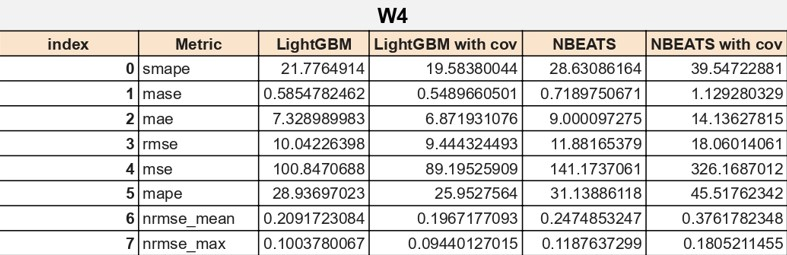

In the headquarter's case, it seems that LightGBM model performs a lot better than NBeats does. MASE for instance, is 0.59 when using the LightGBM model, while for NBEATS is 0.72, both without using past covariates. 

When adding the past covariates we interestingly notice that while this addition worsenes a lot the performance of NBEATS, for LightGBM it seems to make it more effective.

LightGBM's MASE from 0.59 decreases to 0.55 and MAPE from 29.00 to 26.00, with the past covariate addition. 

 **Note**: We have included Normalized Root Mean Squared Error in our metrics, which is calculated as 
NRMSE_mean = RMSE / Y(mean)
NRMSE_max = RMSE / (Ymax` - Ymin)

Further info can be found here -> [https://www.marinedatascience.co/blog/2019/01/07/normalizing-the-rmse/]

*ps: to be continued: i) Q, i & v to be forecasted ii) broadened forecast horizon plus iii)Plots for metrics *